In [1]:
%load_ext autoreload
%autoreload 1
%aimport AnalysisUtils
%aimport genCrossCor
%aimport genMapsfromCor
%aimport run_euclidlike_analysis
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot #to have two axis labels
import mpl_toolkits.axisartist as AA #to have two axis labels
from itertools import permutations
from scipy.optimize import leastsq

In [3]:
import MapParams as mp
import CosmParams as cp #[NJW 160606]
import ClRunUtils as clu
import genCrossCor as gcc
import genMapsfromCor as gmc
import AnalysisUtils as au
import mapdef_utils as mdu
import run_euclidlike_analysis as runeuc
import time
import healpy as hp
import os
import itertools

In [4]:
def getCombos(ls):
    """get list of tuples of all possible combinations of elements of input list ls"""
    a = []
    for L in range(0, len(ls)+1):
        for subset in itertools.combinations(ls, L):
            a.append(subset)
    return a[1:] #first element is blank tuple, so drop

def multi_depthtest_get_binmaps(z0vals=np.array([.3,.6,.7,.8]),includeisw=True, nbar='default'):
#    z0set = set(z0vals)
    tagend = ['']*len(z0vals) #ending to tack on to each survey tag -- default to nothing
#check for duplicates and append name. This is depreciated since duplicate z0 depths are now handled in get_rho and Cl_data object itself,
#which avoids having to duplicate Cl calulations as we would if renamed it at this point.
#     for i,z0 in enumerate(z0vals):
#         instance = (z0vals[:i]==z0).sum()+1 #what instance of z0 is this so far (e.g. "1" = for first 0.3)
#         if instance!= 1:
#             tagend[i] = "_v"+str(instance)
    if nbar!='default':
        surveys=[mdu.get_Euclidlike_SurveyType(z0=z0,onebin=True,nbar=nbar,tag='eucz{0:02d}'.format(int(10*z0))+tagend[i]) for i,z0 in enumerate(z0vals)]
    else: surveys=[mdu.get_Euclidlike_SurveyType(z0=z0,onebin=True,tag='eucz{0:02d}'.format(int(10*z0))+tagend[i]) for i,z0 in enumerate(z0vals)]
    bins=[s.binmaps[0] for s in surveys] #all surveys have only one bin
    if includeisw:
        iswmaptype=mdu.get_fullISW_MapType(zmax=15)
        iswbins=iswmaptype.binmaps
        bins=iswbins+bins
    return bins

def multi_get_Cl(justread=True,z0vals = np.array([.3,.6,.7,.8]),nbar='default', outtag=''): #[added outtag to allow easy spec of different output directory]
    bins=multi_depthtest_get_binmaps(z0vals, nbar=nbar)
    zmax=max(m.zmax for m in bins) #get highest max z of all the binmaps
    rundat = clu.ClRunData(tag='depthtest',rundir='output/'+outtag+'/',lmax=95,zmax=zmax) #keep info like lmax, output dir, tag, zmax, etc. and other general cl information we'll need for all maps
    return gcc.getCl(bins,rundat,dopairs=['all'],DoNotOverwrite=justread)

# same as depthtest_get_reclist, but don't define includeglm so uses all bins instead of limiting to the current bin (i.e. multisurvey)
def multi_depthtest_get_reclist(z0vals=np.array([.3,.6,.7,.8]), multi = False,nbar='default',minl_forrec=2):
    if multi == False:
        multi = range(z0vals) + [(0,1)]
    bins=multi_depthtest_get_binmaps(z0vals,nbar=nbar) #list of bins, since each map is only one bin for depth test
    binlist=[] #bins but without isw_bin0, so corresponds to input z0vals
    for b in bins:
        if b.tag!='isw_bin0':
            binlist.append([b])
        #print b.tag   #make list of lists, with each sublist a list of the bins in the map to use for recreation (only 1 each for now)
    Nrec = len(multi)
    reclist = [0]* Nrec
    for i,irec in enumerate(multi):
        includeglm=[]
        inmaptag = ''
        if type(irec) == int:
            irec = (irec,) #set to tuple so we can reuse upcoming for loop code
            mtag = ''
        else: mtag = '+'
        for m in irec: #for each survey in the list of surveys to use for recon
            for b in binlist[m]: #for each bin in the survey
                bintag=b.tag
                includeglm.append(bintag)
            inmaptag += mtag + bintag[:bintag.rfind('_bin')] #if single map, will be the standard bintag (without '_bin[X]'), if multi will be 'bintag0+bintag1'
        reclist[i] = au.RecData(includeglm=includeglm, inmaptag=inmaptag, minl_forrec=minl_forrec)
#         print (irec,includeglm, inmaptag)
    return reclist
def strp_str(bintag, to_strip='_bin0'):
    """strip '_bin0' from a bintag"""
    return bintag[:bintag.rfind(to_strip)]
def m_binarr_to_labels(maptags,to_strip='_bin0', to_add=''):
        """set [maptagA, maptagB,...] to 'maptagA+maptagB+...+maptagN', with to_strip (string) removed from end of each maptag and to_add appended to full label"""
        return '+'.join([strp_str(mt, to_strip=to_strip) for mt in maptags])+to_add

In [5]:
#use cldat to generate glm, alm, and maps; saves maps but not alm
#   does isw reconstruction automatically
def multi_depthtest_get_glm_and_rec(cldat=False, Nreal=1,z0vals=np.array([.3,.6,.7,.8]),minreal=0,justgetrho=0,dorell=0,dorho=1,dos=1,dochisq=1,dochisqell=0, multi=False, outtag='', nbar='default'):
    t0=time.time()
    if cldat==False:
        if multi==False:
            if nbar!='default': print "Warning, using default nbar instead of passed value!"
            cldat = depthtest_get_Cl(justread=True,z0vals=z0vals,outtag=outtag) #this isn't setup to take nbar yet
        else: cldat = multi_get_Cl(justread=True,z0vals=z0vals,outtag=outtag,nbar=nbar)
    makeplots=Nreal==1
    rlzns=np.arange(minreal,minreal+Nreal)
    if multi:
        reclist = multi_depthtest_get_reclist(z0vals, multi=multi) #try to use all the depth tests in recon
    else: reclist=runeuc.depthtest_get_reclist(z0vals)
    au.getmaps_fromCl(cldat,rlzns=rlzns,reclist=reclist,justgetrho=justgetrho,dorell=dorell,dorho=dorho,dos=dos,dochisq=dochisq,dochisqell=dochisqell)
    t1=time.time()
    print "total time for Nreal",Nreal,": ",t1-t0,'sec'
    
# get expectation values of rho or s, choose variable via varname
def multi_depthtest_get_expected_rho(cldat=False,reclist=False,z0vals=np.array([0.3,0.6,0.7,0.8]),nbar='default',varname='rho',outtag=''):
    if cldat==False: cldat=multi_get_Cl(justread=True, z0vals=z0vals, nbar=nbar, outtag=outtag)
    if reclist==False:
        multi = getCombos(range(len(z0vals))) #by default, get for all possible map combos
        reclist=multi_depthtest_get_reclist(z0vals=z0vals,multi=multi,nbar=nbar)
    rhopred=np.zeros_like(reclist)
    for i,rec in enumerate(reclist):
        rhopred[i] = au.compute_rho_fromcl(cldat,rec,varname=varname)
    return rhopred

def depthtest_get_expected_rell(z0vals=np.array([0.3,0.6,0.7,0.8]),varname='rell'):
    cldat=depthtest_get_Cl(z0vals=z0vals)
    reclist=depthtest_get_reclist(z0vals)
    rellpred=[]
    for i in xrange(z0vals.size):
        rellpred.append(au.compute_rell_fromcl(cldat,reclist[i],varname=varname))
    rellpred=np.array(rellpred)#[Nrec,Nell]
    #print rellpred
    return rellpred

class MRecStats(object):
    """Reconstruction info for multiple maps, e.g. net rho, s, etc. maptag_tuple must be subset of recdat.includeglm"""
    def __init__(self, cldat, recdat, lmin=2, lmax=-1, use_nbar_in_r=True):
        self.maptags = recdat.includeglm
        self.cldat=cldat
        self.recdat=recdat
        self.indiv_reclist = [au.RecData(includeglm=[maptag]) for maptag in self.maptags]
#         print self.indiv_reclist[0].includeglm
        self.Nmaps = len(self.maptags)
        self.lmin = lmin
        if lmax==-1: self.lmax=cldat.Nell-1
        else: self.lmax=lmax
        self.nbar_in_rmap = use_nbar_in_r
        
        #calc ISW Recon stats
        #total <rho> for multimap recon (make sure calls right multi_get expected)
        self.rhoexp = multi_depthtest_get_expected_rho(cldat=self.cldat,reclist=(self.recdat,),varname='rho')[0]
        #array of rho for reconstructions using only the individual maps
        self.rho_arr = np.array([au.compute_rho_fromcl(self.cldat, rec1, varname='rho') for rec1 in self.indiv_reclist])
        #<rho_[AB...N]>/(<rho_A>*<rho_B>*...*<rho_N>)^(1/N)
        self.rho_rat = self.rhoexp/(self.rho_arr.prod())**(1./self.Nmaps)
        
        #s_isw
        self.sexp = multi_depthtest_get_expected_rho(cldat=self.cldat,reclist=(self.recdat,),varname='s')[0]
        self.s_arr = np.array([au.compute_rho_fromcl(self.cldat, rec1, varname='s') for rec1 in self.indiv_reclist])
        self.s_rat = self.sexp/(self.s_arr.prod())**(1./self.Nmaps)
        
        #rho_ell
        
        #calc map-to-map stats:
        self.rmaps=False
        self.rpairs=False
        self.rellmaps=False
        self.rellpairs=False
        self.calc_r(use_nbar=self.nbar_in_rmap)
#         self.label = False
        self.relabel()
        
    def relabel(self, to_strip='_bin0', to_add=''):
        """set self.label to 'maptagA+maptagB+...+maptagN', with to_strip (string) removed from end of each maptag and to_add appended to full label"""
        self.label = '+'.join([strp_str(mt, to_strip=to_strip) for mt in self.maptags])+to_add
        
    def calc_r(self, use_nbar):
        if self.Nmaps==2:
            #for only two maps, rmaps and rpairs are same
            self.rmaps = [au.get_r_for_maps(self.cldat,self.maptags[0],self.maptags[1], self.lmin, self.lmax,include_nbar=use_nbar)[0]]
            self.rpairs = self.rmaps[:] #need to slice, else will just reference rmaps array directly
            self.rellmaps = [au.get_r_for_maps(self.cldat,self.maptags[0],self.maptags[1], self.lmin, self.lmax,include_nbar=use_nbar)[1]]
            self.rellpairs = self.rellmaps[:]
        elif self.Nmaps==3: #rmaps has 
            r3_to_calc = [(1,2,0), (2,0,1), (0,1,2)] #third element in each tuple is map to add
            #[[(maptagB, maptagC), maptagA],[(maptagC,maptagA),maptagB], ...] #each element has info to create one r3
            mtuple_list = [[(self.maptags[t[0]], self.maptags[t[1]]), self.maptags[t[2]]] for t in r3_to_calc]
            #get multiple correlation coeff of one map with the other two [R_bc_a, R_ac_b, R_ab_c]
            self.rmaps = [au.get_r3_for_maps(self.cldat, m[0], m[1], self.lmin, self.lmax,include_nbar=use_nbar,tot_or_ell='tot')[0] for m in mtuple_list]
            #get pairwise correlations [r_ab, r_bc, r_ac]
            self.rpairs = au.get_r3_for_maps(self.cldat, mtuple_list[2][0], mtuple_list[2][1],self.lmin,self.lmax,include_nbar=use_nbar, tot_or_ell='tot')[1]
            self.rellmaps = [au.get_r3_for_maps(self.cldat, m[0], m[1], self.lmin, self.lmax, include_nbar=use_nbar, tot_or_ell='ell')[0] for m in mtuple_list]
            #get pairwise correlations by ell [rell_ab, rell_bc, rell_ac]
            self.rellpairs = au.get_r3_for_maps(self.cldat, mtuple_list[2][0], mtuple_list[2][1],self.lmin,self.lmax,include_nbar=use_nbar,tot_or_ell='ell')[1]

        elif self.Nmaps > 3: print "4+ maps in reconstruction -- can only compute r for up to 3 maps"

In [6]:


print cldat.Nmap
print cldat.crossinds[cl_dat.Nmap-1,cl_dat.Nmap-1]
print cldat.tagdict
print cldat.bintaglist
# xind=cldatdat.crossinds[2,2]
# xslice = [cldat.crossinds[i,1] for i in xrange(cld_dat.Nmaps)]
# print xslice
# print cldat.noisecl[:,1]

NameError: name 'cldat' is not defined

In [7]:
# cl_dat2 = multi_get_Cl(justread=False,z0vals=depthtestz0, nbar=nbar, outtag=outtag)
# print cl_dat2.bintaglist
#cl_dat2.add_dupemap('eucz03_bin0')
#print cldat.docross
print m_binarr_to_labels(cldat.bintaglist)

NameError: name 'cldat' is not defined

In [8]:
outtag = 'depthtest_multi01'
st = time.time()
depthtestz0=np.array([.3,.5,.7,.9])
nbar = 'default'
#rho_AB/(rho_a*rho_b) vs. r_AB
cldat=multi_get_Cl(justread=True,z0vals=depthtestz0, nbar=nbar, outtag=outtag)
#doMulti = getCombos(range(len(depthtestz0))) #list of z0val map indices to combine for reconstruction.
doMulti2 = [0,1,2,3,(0,0),(1,1),(2,2),(3,3),(0,1),(0,2),(0,3),(1,2),(1,3),(2,3)] #getCombos(range(len(depthtestz0))) #list of z0val map indices to combine for reconstruction.
reclist = multi_depthtest_get_reclist(depthtestz0, multi=doMulti2, nbar=nbar)
mrs = [MRecStats(cldat, rec, use_nbar_in_r=True) for rec in reclist]
irs=[irec for irec in mrs if irec.Nmaps==1]#get the single reconstructions
mrs=[mrec for mrec in mrs if mrec.Nmaps>1]
mrs_noN = [MRecStats(cldat, rec, use_nbar_in_r=False) for rec in reclist]
irs_noN=[irec for irec in mrs_noN if irec.Nmaps==1]#get the single reconstructions
mrs_noN=[mrec for mrec in mrs_noN if mrec.Nmaps>1]

print "\nNmaps:",[recdat.Nmap for recdat in reclist]
print "\nMaps to include:\n",[recdat.includeglm for recdat in reclist]
# rhopred = multi_depthtest_get_expected_rho(cldat=cldat,reclist=reclist,varname='rho')
print cldat.bintaglist
print "Done! Minutes elapsed:",(time.time()-st)/60.

Initializing Kdata:
kmin=1.000e-05, kmax=1.000e+01, kperlog=300, krcut(add,mult)=(50,20);
 Initializing instance of Cosmology
  Importing cosm params from: testparam.cosm
in getCL, DoNotOverwrite= True
Getting C_l for auto-corr and requested pairs: ['all']
Reading C_l file: output/depthtest_multi01/Cl_output/Cl_depthtest.dat
    Using previously computed auto-corr.
  Checking for previously computed C_l values.
    No new values needed.

Nmaps: [1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

Maps to include:
[['eucz03_bin0'], ['eucz05_bin0'], ['eucz07_bin0'], ['eucz09_bin0'], ['eucz03_bin0', 'eucz03_bin0'], ['eucz05_bin0', 'eucz05_bin0'], ['eucz07_bin0', 'eucz07_bin0'], ['eucz09_bin0', 'eucz09_bin0'], ['eucz03_bin0', 'eucz05_bin0'], ['eucz03_bin0', 'eucz07_bin0'], ['eucz03_bin0', 'eucz09_bin0'], ['eucz05_bin0', 'eucz07_bin0'], ['eucz05_bin0', 'eucz09_bin0'], ['eucz07_bin0', 'eucz09_bin0']]
['isw_bin0', 'eucz03_bin0', 'eucz05_bin0', 'eucz07_bin0', 'eucz09_bin0']
Done! Minutes elapsed: 0.011

In [9]:
print '(mrs.maptags, mrs.rpairs[0], mrs.rhoexp, mrs.rho_arr, mrec.rmaps)'
for mrec in mrs:
    print (mrec.label, mrec.rpairs, mrec.rhoexp, list(mrec.rho_arr),mrec.rmaps)
for mrec in irs:
    print (mrec.label, mrec.rpairs, mrec.rhoexp, list(mrec.rho_arr),mrec.rmaps)

(mrs.maptags, mrs.rpairs[0], mrs.rhoexp, mrs.rho_arr, mrec.rmaps)
('eucz03+eucz03', [1.0], 0.66613578319765987, [0.66607551484611316, 0.66607551484611316], [1.0])
('eucz05+eucz05', [1.0], 0.85142960370209297, [0.85097910619297323, 0.85097910619297323], [1.0])
('eucz07+eucz07', [1.0], 0.92864620344671045, [0.92705662090902985, 0.92705662090902985], [1.0])
('eucz09+eucz09', [1.0], 0.94680877207764769, [0.94297374798989519, 0.94297374798989519], [1.0])
('eucz03+eucz05', [0.84084054660392871], 0.86934298124074161, [0.66607551484611316, 0.85097910619297323], [0.84084054660392871])
('eucz03+eucz07', [0.63337413676903809], 0.92757595155005257, [0.66607551484611316, 0.92705662090902985], [0.63337413676903809])
('eucz03+eucz09', [0.47777633765143629], 0.95638296037108317, [0.66607551484611316, 0.94297374798989519], [0.47777633765143629])
('eucz05+eucz07', [0.9245186456668063], 0.92908964889667878, [0.85097910619297323, 0.92705662090902985], [0.9245186456668063])
('eucz05+eucz09', [0.79455170955

In [10]:
def labplot_r(xr, yr, mlabels, xaxis='', yaxis='',show=True,ha='left',seq_label=''): #seqlabel is e.g. rho_ratio, vs mlabel is label for each multi-recon
    p = plt.plot(xr, yr, '.',label=seq_label)
    for label, x, y in zip(mlabels, xr, yr):
        plt.annotate(
            label, 
            xy = (x+0.01, y+0.0005), xytext = (20, 20),
            textcoords = 'offset points', ha = ha, va = 'bottom',
            bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.3),
            arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
    plt.xlabel(xaxis)
    plt.ylabel(yaxis)
    plt.grid()
    if show: plt.show()
    else: return p
    
def labplot_s(xr, yr, mlabels, xaxis='', yaxis='',show=True,ha='right',seq_label=''):
    p = plt.plot(xr, yr, '.',label=seq_label)
    for label, x, y in zip(mlabels, xr, yr):
        plt.annotate(
            label, 
            xy = (x-0.005, y+0.005), xytext = (-20, 20),
            textcoords = 'offset points', ha = ha, va = 'bottom',
            bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.3),
            arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
    plt.xlabel(xaxis)
    plt.ylabel(yaxis)
    plt.grid()
    if show: plt.show()
    else: return p

In [11]:
def plotnfit(xarr, ytests, labels, deg=1, cmap='jet_r'):
    N = len(ytests)
    xtests=[xarr]*N
    cmap = plt.get_cmap(cmap)
    for i,(xarr,yarr,label) in enumerate(zip(xtests,ytests,labels)):
        color = cmap(float(i)/((2*N-1)))
        plt.plot(xarr,yarr,'o',label=label, color=color)
        coeffs = np.polyfit(xarr,yarr,deg=deg)
        if deg > 0:
            yfit = np.polyval(coeffs, np.sort(xarr)) #Evaluates the polynomial for each x2 value
            plt.plot(np.sort(xarr),yfit,'-',color=color)
    plt.grid()
    return
# labplot_r(x_rpairs,x_rho_rat,labels2,'r_map', 'rho_AB/sqrt(rhoA*rhoB)',show=False)
# plt.plot(x_rpairs_noN,x_rho_rat,'r.',label='No Noise')
rhomod1 = [mrec.rhoexp/np.max(mrec.rho_arr) for mrec in mrs]
rhomod2 = [mrec.rhoexp/np.min(mrec.rho_arr) for mrec in mrs]
labels22 = ['rho_rat (rho_AB/sqrt[rho_A*rho_B])','rho_AB/rho_best','rho_AB/rho_worst']

ytests = [x_rho_rat,rhomod1, rhomod2]
# for i,(yarr,label) in enumerate(zip(ytests,labels22)):
#     xarr = x_rpairs
#     color = cmap(float(i)/len(ytests))
#     plt.plot(xarr,yarr,'o',label=label, color=color)
#     coeffs = np.polyfit(xarr,yarr,deg=1)
#     yfit = np.polyval(coeffs, xarr) #Evaluates the polynomial for each x2 value
#     plt.plot(xarr,yfit,'-',color=color)
plotnfit(x_rpairs,ytests,labels22, deg=1)
plt.legend(loc='best')
# plt.xlim(.55,1.1)
# plt.ylim(.95,1.25)
plt.grid(True)
plt.title('Multi Recon Improvement over individual vs r_map')
plt.xlabel('r_maps')
plt.ylabel('dimless improvement vs. individual(see key)')
plt.show()

#s
smod1 = [mrec.sexp/np.min(mrec.s_arr) for mrec in mrs] #note that i switch min and max here since a low s corresponds to a higher rho, so dividing out same map.
smod2 = [mrec.sexp/np.max(mrec.s_arr) for mrec in mrs]

slabels= ['s_rat (s_AB/sqrt[s_A*rho_B])','s_AB/s_best','s_AB/s_worst']
ytests2 = [x_s_rat,smod1, smod2]
plotnfit(x_rpairs,ytests2,slabels, deg=1)
plt.legend(loc='best')
# plt.xlim(.55,1.1)
# plt.ylim(.95,1.25)
plt.grid(True)
plt.title('Multi Recon Improvement over individual vs r_map')
plt.xlabel('r_maps')
plt.ylabel('dimless improvement vs. individual(see key)')
plt.show()

NameError: name 'x_rho_rat' is not defined

In [12]:
labplot_s(x_rpairs, x_rhoexp, labels2, 'r_map','rho_AB',show=False)
for irec in irs:
    plt.plot(np.linspace(.4,1.1,10),[irec.rhoexp]*10,'--',label=irec.label)
plt.xlim(.4,1.1)
plt.legend(loc='best')
plt.show()
labplot_s(x_rpairs, x_sexp, labels2, 'r_map', 's_AB',show=False)
for irec in irs:
    plt.plot(np.linspace(.4,1.1,10),[irec.sexp]*10,'--',label=irec.label)
plt.show()
#labplot_r(mrecstats[0].rell, mrecstats[0].rhoell)

NameError: name 'x_rpairs' is not defined

In [13]:
def plot_mrslist(mrs, vartypes='rat',title=False, fitdeg=0, labplot=False): #vartype one of {'raw', rat', 'rat_best', 'rat_worst'}

    irs=[irec for irec in mrs if irec.Nmaps==1]#get the single reconstructions
    mrs=[mrec for mrec in mrs if mrec.Nmaps>1]

    x_rhoexp = [mrec.rhoexp for mrec in mrs]
    x_rho_rat = [mrec.rho_rat for mrec in mrs]
    x_sexp = [mrec.sexp for mrec in mrs]
    x_s_rat = [mrec.s_rat for mrec in mrs]
    x_ssymexp = [mrec.sexp for mrec in mrs]
    x_ssym_rat = [mrec.s_rat for mrec in mrs]

    x_rpairs = [mrec.rpairs[0] for mrec in mrs]
    mlabels2=[mrec.label for mrec in mrs]
    
    ylist=[]
    rhobest = [mrec.rhoexp/np.max(mrec.rho_arr) for mrec in mrs]
    rhoworst = [mrec.rhoexp/np.min(mrec.rho_arr) for mrec in mrs]
    labels22 = []
    
    slist=[]
    sbest = [mrec.rhoexp/np.max(mrec.rho_arr) for mrec in mrs]
    sworst = [mrec.rhoexp/np.min(mrec.rho_arr) for mrec in mrs]
    slabels22 = []
    if type(vartypes) == str: vartypes=[vartypes]
    if 'raw' in vartypes:
        ylist.append(x_rhoexp)
        labels22.append('rho_raw')
        slist.append(x_sexp)
        slabels22.append('s_raw')
    if 'rat' in vartypes:
        ylist.append(x_rho_rat)
        labels22.append('rho_rat')
        slist.append(x_s_rat)
        slabels22.append('s_rat')
    if 'rat_best' in vartypes:
        ylist.append(rhobest)
        labels22.append('rho_AB/rho_best') 
        slist.append(sbest)
        slabels22.append('s_AB/s_best') 
    if 'rat_worst' in vartypes:
        ylist.append(rhoworst)
        labels22.append('rho_AB/rho_worst')
        slist.append(sworst)
        slabels22.append('s_AB/s_worst')
    if labplot:
        N = len(ylist)
        for x,y,mlab,varlab in zip([x_rpairs]*N, ylist, [mlabels2]+['']*(N-1), labels22):
            labplot_r(x,y,mlab,'r_map', 'rho various',ha='left',show=False,seq_label=varlab)
            if title: plt.title(title)
            plt.legend(loc='best')
        plt.xlim(0.95*min(x_rpairs), 1.05*max(x_rpairs))
        plt.show()
        for x,y,mlab,varlab in zip([x_rpairs]*N, slist, [mlabels2]+['']*(N-1), slabels22):
            labplot_s(x,y,mlab,'r_map', 's various',ha='right',show=False,seq_label=varlab)
            plt.legend(loc='best')
        plt.xlim(0.95*min(x_rpairs), 1.05*max(x_rpairs))
        plt.show()
    else:
        plotnfit(x_rpairs, ylist, labels22, deg=fitdeg)
        if title:
            plt.title(title)
        plt.show()
    plt.legend(loc='best')
    print x_rpairs

In [14]:
def getShapeStr(lmin,lmax,width,shape='g'):
    if shape=='g':
        shapestr='g{2:d}_{0:d}l{1:d}'.format(lmin,lmax,int(width))
    elif shape=='l2':
        shapestr='l2_{0:d}l{1:d}'.format(lmin,lmax)
    return shapestr

def m_caltest_get_rhoexp(z0_base=0.7,z0_sup=0.7,basevar=0,varlist=[1.e-4],lmax=30,lmin=1,shape='g',width=10.,
                         overwrite=False,doplot=True,saverho=True,varname='rho',filetag='',reclmin=1,
                         plotdir='output/m_caltest_plots/',nolmintag=False,dofidrec=True,nbar='default',outtag=''):
    """give z0_base and z0_sup, where the latter is the map to add to the first to see improvement and which gets the list of calib variances in varlist applied.
    basevar defines a calib error to apply to the basemap.
    Set z0_base = 0 to do recon with just one map"""
    #note this makes a parallel track for single map recon with caltest_get_rhoexp,
    #but would prefer not to edit guts of that one to, e.g. pass a Cl, as it also defines an output loc, etc. and don't want to risk
    #messing it up. It should be obvious from calc and output which way it was created, and this will allow comparison of the two methods.
    dupesuf = '_sup' #if comparing two surveys of same depth, need two sets of Cls. The duplicate will be the "supplemental" map
    single_map=False
    if z0_base == False:
        single_map = True
    
    shapestr=getShapeStr(lmin=lmin,lmax=lmax,width=width,shape=shape)
    if single_map: z0_vals = [z0_sup] 
    else: z0_vals = [z0_base,z0_sup] #will need to change this is use multiple base bins
            
    fidbins=multi_depthtest_get_binmaps(z0_vals,nbar=nbar) #only need this to get the bin name, but now we're passing those in.
    lssbins=[fb.tag for fb in fidbins[1:]] #ignore the first entry (ISW)
    #fidcl=caltest_get_clfid(z0fid)

    #if z0_base == z0_sup, will use autopower, so pass set(z0_vals). If change to make z0_sup a list, will need to change this implementation
    fidcl=multi_get_Cl(justread=not(overwrite),z0vals=set(z0_vals), nbar=nbar, outtag=outtag)
    
    recdat = au.RecData(includeglm=lssbins,inmaptag=m_binarr_to_labels(lssbins),minl_forrec=reclmin)
#     recdat = multi_depthtest_get_reclist(z0_vals, multi=doMulti, nbar=nbar,minl_forrec=reclmin)[0]
    #get recdat; only need to pass maptags, not modtags, since cldata objects
    #  note that this means we can use the same recdat for all variances
    #recdat=au.RecData(includeglm=lssbins,inmaptag=m_binarr_to_labels(lssbins),minl_forrec=reclmin)
    if len(set(z0_vals)) != len(z0_vals): #if there are duplicates, account for for this and change names accordingly
#         print fidcl.bintaglist
#         print lssbins
        fidcl,recdat = au.handle_dupes(fidcl, recdat, dupesuf=dupesuf)
        #lssbins[1] = lssbins[1]+dupesuf
        lssbins = recdat.includeglm
#         print fidcl.bintaglist
#         print recdat.includeglm
        assert [bn in fidcl.bintaglist for bn in lssbins] #verify all newly named lss bins are in bintaglist
    basebins = lssbins[:-1] #last entry is the map we're adding, assuming we already have the others (can't handle more than one base yet)
    supbin = lssbins[-1]
    if saverho:
        outdir = 'output/'+outtag+'/m_caltest_plots/'
        if filetag:
            filetagstr='_'+filetag
        else:
            filetagstr=''
        if not nolmintag: #for compatibility with older, pre-lmintest data
            reclminstr="-lmin{0:02d}".format(reclmin)
            filetagstr=filetagstr+reclminstr
        datfile='m_caltest_'+'z{0:02d}+z{1:02d}_bvar{5:02e}_{2:s}_{3:s}exp{4:s}.dat'.format(z0_base,z0_sup,shapestr,
                                                                                            varname,filetagstr,basevar)
        if not overwrite and os.path.isfile(outdir+datfile): #file exists
            print 'Reading data file:',datfile
            x=np.loadtxt(outdir+datfile,skiprows=2)
            invarlist=x[:,0]
            if not np.all(invarlist==np.array(varlist)):
                print "WARNING, invarlist!=varlist, overwriting"
            else:
                rhoarray=x[:,1]
                return rhoarray
        else:
            print 'Writing to data file:',datfile

    #construct map-mod combos for the variances given
    mapmods_sup=runeuc.caltest_getmapmods_onebin(supbin,varlist,lmax,lmin,shape,width)
#     print 'mapmods_sup:',mapmods_sup
    #generate calibration errors with fixed variance, spread through Cl lmin-lmax
    clmodlist=[]
#     print fidcl.bintaglist
#     print '\nfidcl supbin autopower l=0,5:  {0}, {1}'.format(fidcl.get_cl_from_pair(supbin,supbin,0),fidcl.get_cl_from_pair(supbin,supbin,5))
    if not single_map: #if we are using two or more maps for recon (set z0_base=False for only a single recon)
        assert len(basebins) == 1 #THIS ONLY WORKS FOR ONE MAP AS THE BASE MAP. NEED TO ADJUST IF USING MORE THAN ONE
        if type(basevar)==list: 
            assert len(basevar)==len(varlist), "variance of base map given as list length {0},\
                                                but must be same length as varlist for supplemental map ({1})".format(len(basevar),len(varlist))
            mapmods_base=runeuc.caltest_getmapmods_onebin(basebins[0],basevar,lmax,lmin,shape,width) #vary the basemap variance
            print 'Varying basemap variance along with sup-map variance'
        else: #do all calcs using same basevar
            mapmods_base=runeuc.caltest_getmapmods_onebin(basebins[0],[basevar]*len(varlist),lmax,lmin,shape,width) #mod to z0_base
        #for each variance, get calib error Cl
            #(note, this is an inefficient way to do this, since mm_base will be same everytime)
        for (mm_base, mm_sup) in zip(mapmods_base, mapmods_sup): #add calib errors according to (map, var[c]) for each base and sup maps
            #print 'INRHOEXP---modding Cl---',mm
            clmod=gmc.apply_additive_caliberror_tocl(fidcl,[mm_base, mm_sup])
            clmodlist.append(clmod)
#             print 'clmod basebn autopower l=0,5:  {0}, {1}'.format(clmod.get_cl_from_pair(basebins[0],basebins[0],0),clmod.get_cl_from_pair(basebins[0],basebins[0],5))
#             print 'clmod supbin autopower l=0,5:  {0}, {1}'.format(clmod.get_cl_from_pair(supbin,supbin,0),clmod.get_cl_from_pair(supbin,supbin,5))

#         print 'mm_base,mm_sup[:5]=',zip(mapmods_base[:5], mapmods_sup[:5])
    else: #only single map, so only considering z0_sup map in recon
        for mm_sup in mapmods_sup: #add calib errors according to (map, var[c]) for sup maps
            clmod=gmc.apply_additive_caliberror_tocl(fidcl,[mm_sup])
#             print 'clmod supbin autopower l=0,5:  {0}, {1}'.format(clmod.get_cl_from_pair(supbin,supbin,0),clmod.get_cl_from_pair(supbin,supbin,5))
            clmodlist.append(clmod)
#         print 'mm_sup[::10]=',mapmods_sup[:10]
#     clbase=gmc.apply_additive_caliberror_tocl(fidcl,[mapmod_base]) #add calib errors to base LSS map
#     print fidcl.bintaglist
#     print clbase.bintaglist

    # include fidicual cl as last entry
    if varlist[-1]!=0. and dofidrec:
#         print "  appending fiducial case, no calib error"
        varlist.append(0.)
        clmodlist.append(fidcl)

    # return array of shape [Nvar,Nell]
    Nrec=len(varlist)
    rhoarray=np.zeros(Nrec)
    for r in xrange(Nrec):
        #print '--ON VAR=',varlist[r],'---------'
        rhoarray[r]=au.compute_rho_fromcl(clmodlist[r],recdat,reccldat=fidcl,varname=varname)
#         print 'fidcl tags:',fidcl.bintaglist
    #if save, write to file
    if saverho:
        f=open(outdir+datfile,'w')
        f.write('Multi calib error test: Clcal shape={0:s}, ell={1:d}-{2:d}, z0_base={3:.2d} (var(c)={4:.2e}), z0_sup={5:.2d}\n'.format(shape,lmin,lmax,z0_base,basevar,z0_sup))
        f.write('sup var(c(nhat))   <{0:s}>\n'.format(varname))
        f.write(''.join(['{0:.2e} {1:8.3f}\n'.format(varlist[i],rhoarray[i]) for i in xrange(Nrec)]))
        f.close()

    if doplot:
        runeuc.caltest_rhoexpplot(varlist,rhoarray,varname=varname,outtag=shapestr,plotdir=plotdir)
    return rhoarray
####--------- cell 2

In [17]:
def calplotsetup(fig=False):
    """call before calplotform to setup figure and axis. Plot desired lines between the two function calls via ax1.plot(...)."""
    if not fig:
        fig=plt.figure(figsize=(10,6))#(7,4))
        fig.subplots_adjust(bottom=.2)
        fig.subplots_adjust(left=.175)
        fig.subplots_adjust(right=.95)
    ax1 = plt.subplot()
    return (fig,ax1)
def calplotform(axis, varname='rho',show=False):
    """Pass axis, format like caltest rho and s plots in paper. Plot actual curves explicitly then call this"""
    ax1 = axis
    #--- resume plotting details
#     linelabel='Theory (add. only)'
    for item in ([ax1.xaxis.label, ax1.yaxis.label] + ax1.get_xticklabels()
                  + ax1.get_yticklabels()):
        item.set_fontsize(18)
    for item in ([ax1.yaxis.label]):
        item.set_fontsize(22)
    plt.sca(ax1)
    ax1.grid(True)
    ax1.set_xscale('log')
    ax1.set_xlim((10**-8,10**-1.5))#(10**-7.5,10**-1.5))
    ax1.set_xlabel(r'Variance of calib. error field ${\rm var}[c]$')
    ax1.axhline(0,color='grey',linestyle='-')
    if varname=='rho':
        ax1.set_ylim(0,1)#(-.3,1.3)
        ax1.axhline(1,color='grey',linestyle='-')
        ax1.set_ylabel(r'$\rho$')
    elif varname=='s':
        ax1.set_ylabel(r'$s$')
        ax1.set_ylim((.1,3.))

    #fill in regions for current/future values
    nowmin=1.e-4
    nowmax=1.e-3
    nowcenter=10**(.5*(np.log10(nowmin)+np.log10(nowmax)))
    nowlabel='current'
    nowcol='#377eb8'
    futuremin=1.e-6
    futuremax=1.e-5
    futurecenter=10**(.5*(np.log10(futuremin)+np.log10(futuremax)))
    futurelabel='future'
    futurecol='#4daf4a'
    ymin,ymax=ax1.get_ylim()
    ##plt.fill_between(varlist[:-1],ymin,ymax, facecolor=nowcol,edgecolor='none',linewidth=2, alpha=0.3)
    ax1.axvspan(nowmin,nowmax,alpha=0.1,color=nowcol)
    plt.annotate(nowlabel,xy=(nowcenter,ymin),horizontalalignment='center',verticalalignment='bottom',fontsize=16,color=nowcol)
    ax1.axvspan(futuremin,futuremax,alpha=0.1,color=futurecol)
    plt.annotate(futurelabel,xy=(futurecenter,ymin),horizontalalignment='center',verticalalignment='bottom',fontsize=16,color=futurecol)

    ##data points should just have one entry, but copying whole mess anyway
    # for i in xrange(len(datplot)):
    #     datvar=datplot[i][0]#array
    #     datrho=datplot[i][1]#array
    #     datlabel=datplot[i][2] #string
    #     datNreal=0
    #     datcol=datplot[i][3]
    #     datsig=datplot[i][4]         
    #     datrefmean=datplot[i][5]
    #     if len(datplot[i])>5:
    #         datNreal=datplot[i][6]
    #     if not datcol:
    #         datcol=colorlist[0]
    #     ax1.errorbar(datvar,datrho,yerr=datsig,label=datlabel,color=datcol,linestyle='None',marker='o')    

    plt.sca(ax1)
    if varname=='rho':
        plt.legend(fontsize=10,loc='upper right',numpoints=1)
    elif varname=='s':
        plt.legend(fontsize=8,loc='upper left',numpoints=1)

    # print 'Saving plot to ',plotdir+outname
    # plt.savefig(plotdir+outname)
    # plt.close()
    if show: plt.show
    return ax1

Initializing Kdata:
kmin=1.000e-05, kmax=1.000e+01, kperlog=300, krcut(add,mult)=(50,20);
 Initializing instance of Cosmology
  Importing cosm params from: testparam.cosm
in getCL, DoNotOverwrite= False
Getting C_l for auto-corr and requested pairs: ['all']
Reading C_l file: output/mCal04_fidz0_bv0/Cl_output/Cl_depthtest.dat
    Using previously computed auto-corr.
  Checking for previously computed C_l values.
    No new values needed.
Varying basemap variance along with sup-map variance
Initializing Kdata:
kmin=1.000e-05, kmax=1.000e+01, kperlog=300, krcut(add,mult)=(50,20);
 Initializing instance of Cosmology
  Importing cosm params from: testparam.cosm
in getCL, DoNotOverwrite= False
Getting C_l for auto-corr and requested pairs: ['all']
Reading C_l file: output/mCal04_fidz0_bv0/Cl_output/Cl_depthtest.dat
    Using previously computed auto-corr.
  Checking for previously computed C_l values.
    No new values needed.
Initializing Kdata:
kmin=1.000e-05, kmax=1.000e+01, kperlog=300, 

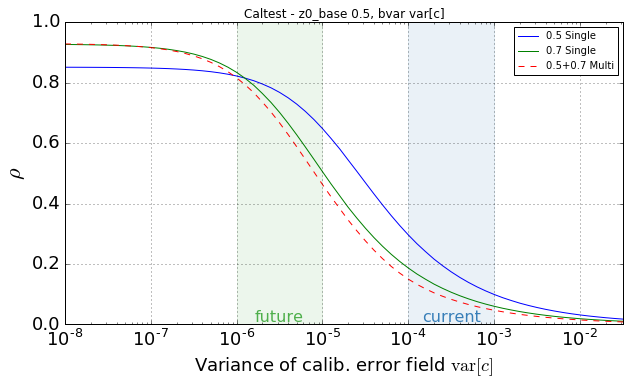

Initializing Kdata:
kmin=1.000e-05, kmax=1.000e+01, kperlog=300, krcut(add,mult)=(50,20);
 Initializing instance of Cosmology
  Importing cosm params from: testparam.cosm
in getCL, DoNotOverwrite= False
Getting C_l for auto-corr and requested pairs: ['all']
Reading C_l file: output/mCal04_fidz0_bv0/Cl_output/Cl_depthtest.dat
    Using previously computed auto-corr.
  Checking for previously computed C_l values.
    No new values needed.
Varying basemap variance along with sup-map variance
Initializing Kdata:
kmin=1.000e-05, kmax=1.000e+01, kperlog=300, krcut(add,mult)=(50,20);
 Initializing instance of Cosmology
  Importing cosm params from: testparam.cosm
in getCL, DoNotOverwrite= False
Getting C_l for auto-corr and requested pairs: ['all']
Reading C_l file: output/mCal04_fidz0_bv0/Cl_output/Cl_depthtest.dat
    Using previously computed auto-corr.
  Checking for previously computed C_l values.
    No new values needed.
Initializing Kdata:
kmin=1.000e-05, kmax=1.000e+01, kperlog=300, 

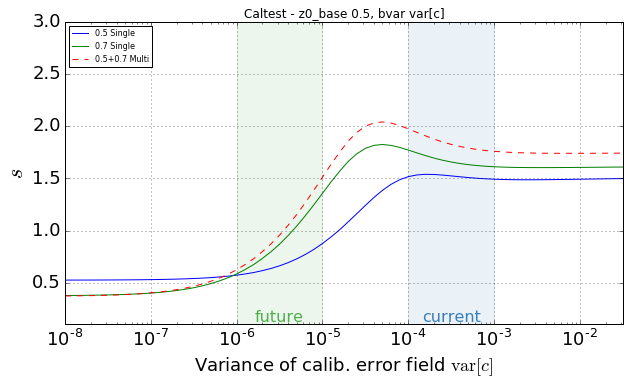

In [27]:
z0_base=0.5
basevar=0
z0_sup = 0.8
nbar='default'
z0list_toplot=[.3,.4,.5,.6,.7,.8,.9]#[.1,.2,.3,.4,.5,.6,.7, .8, .9]
#Cal test Multi:
#==========================================
# v v v----- This function (caltest_basic_expplot_forpaper) is from GPFP module. Using to guide mu
# plots rho exp and data points for one shape and lmin
#combine stuff from caltest_compare_clcal_shapes with rhoexpplot
outtag='mCal04_fidz0_bv0'
varname = 'rho'
plotdir='output/'+outtag+'/plots_forpaper/'

#def caltest_basic_expplot_forpaper(varname='rho',plotdir='output/plots_forpaper/'):
outname='caltest_'+varname+'_exp_basic.pdf'
#outname='caltest_'+varname+'_exp_test.pdf'
colorlist=['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00']#qualitative
reclmin=2
#info about calibration errors
shape='g'
width=10.
lmincal=0#min ell for calib error
lmaxcal=30#max ell for caliberror

#what points to plot
varlist=list(runeuc.caltest_get_logspaced_varlist(minvar=1.e-8,maxvar=100,Nperlog=10))
shortvarlist=[1.e-7,1.e-6,1.e-5,1.e-4,1.e-3,1.e-2]#for data points

rhoexplist=[]#will be 1D; [variance ] 

for varname in ['rho','s']:
    fig, ax1 = calplotsetup()
    for (z0_1,z0_2) in [(.5,.7)]:#(.3,.5),(.5,.7),(.7,.3)]:
        basevar_temp = varlist
        rhoexp_temp = m_caltest_get_rhoexp(z0_base=z0_1, z0_sup=z0_2, basevar=basevar_temp,varlist=varlist,lmax=lmaxcal,lmin=lmincal,
                                    shape=shape,width=width,overwrite=True,doplot=False,saverho=False,varname=varname,
                                    reclmin=reclmin,outtag=outtag)  
        rhoexp_temp_sing1 = m_caltest_get_rhoexp(z0_base=False, z0_sup=z0_1, basevar=False,varlist=varlist,lmax=lmaxcal,lmin=lmincal,
                                    shape=shape,width=width,overwrite=True,doplot=False,saverho=False,varname=varname,
                                    reclmin=reclmin,outtag=outtag)
        rhoexp_temp_sing2 = m_caltest_get_rhoexp(z0_base=False, z0_sup=z0_2, basevar=False,varlist=varlist,lmax=lmaxcal,lmin=lmincal,
                                    shape=shape,width=width,overwrite=True,doplot=False,saverho=False,varname=varname,
                                    reclmin=reclmin,outtag=outtag)
        ax1.plot(varlist[:-1],rhoexp_temp_sing1[:-1],'-',label='{0:.1} Single'.format(z0_1,))
        ax1.plot(varlist[:-1],rhoexp_temp_sing2[:-1],'-',label='{0:.1} Single'.format(z0_2,))
        ax1.plot(varlist[:-1],rhoexp_temp[:-1],'--',label='{0:.1}+{1:.1} Multi'.format(min(z0_1,z0_2),max(z0_1,z0_2)))
    ax1=calplotform(ax1,varname=varname) #format like caltest plot
    if basevar_temp==varlist: bvlabel = 'var[c]'
    else: bvlabel='{0}'.format(basevar,)
    # plt.title('z0base={0}, z0sup={1}, basevar={2}'.format(z0_base,z0_sup,bvlabel))
    plt.title('Caltest - z0_base {0:.1f}, bvar {1}'.format(z0_base,bvlabel))
    plt.show()

Initializing Kdata:
kmin=1.000e-05, kmax=1.000e+01, kperlog=300, krcut(add,mult)=(50,20);
 Initializing instance of Cosmology
  Importing cosm params from: testparam.cosm
in getCL, DoNotOverwrite= False
Getting C_l for auto-corr and requested pairs: ['all']
Reading C_l file: output/mCal04_fidz0_bv0/Cl_output/Cl_depthtest.dat
    Using previously computed auto-corr.
  Checking for previously computed C_l values.
    No new values needed.
Initializing Kdata:
kmin=1.000e-05, kmax=1.000e+01, kperlog=300, krcut(add,mult)=(50,20);
 Initializing instance of Cosmology
  Importing cosm params from: testparam.cosm
in getCL, DoNotOverwrite= False
Getting C_l for auto-corr and requested pairs: ['all']
Reading C_l file: output/mCal04_fidz0_bv0/Cl_output/Cl_depthtest.dat
    Using previously computed auto-corr.
  Checking for previously computed C_l values.
    No new values needed.
Initializing Kdata:
kmin=1.000e-05, kmax=1.000e+01, kperlog=300, krcut(add,mult)=(50,20);
 Initializing instance of Co

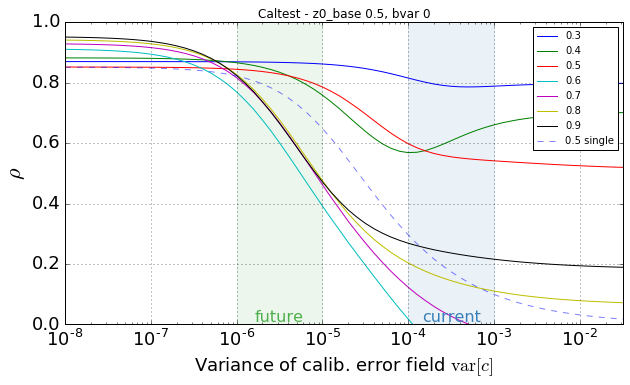

Initializing Kdata:
kmin=1.000e-05, kmax=1.000e+01, kperlog=300, krcut(add,mult)=(50,20);
 Initializing instance of Cosmology
  Importing cosm params from: testparam.cosm
in getCL, DoNotOverwrite= False
Getting C_l for auto-corr and requested pairs: ['all']
Reading C_l file: output/mCal04_fidz0_bv0/Cl_output/Cl_depthtest.dat
    Using previously computed auto-corr.
  Checking for previously computed C_l values.
    No new values needed.
Initializing Kdata:
kmin=1.000e-05, kmax=1.000e+01, kperlog=300, krcut(add,mult)=(50,20);
 Initializing instance of Cosmology
  Importing cosm params from: testparam.cosm
in getCL, DoNotOverwrite= False
Getting C_l for auto-corr and requested pairs: ['all']
Reading C_l file: output/mCal04_fidz0_bv0/Cl_output/Cl_depthtest.dat
    Using previously computed auto-corr.
  Checking for previously computed C_l values.
    No new values needed.
Initializing Kdata:
kmin=1.000e-05, kmax=1.000e+01, kperlog=300, krcut(add,mult)=(50,20);
 Initializing instance of Co

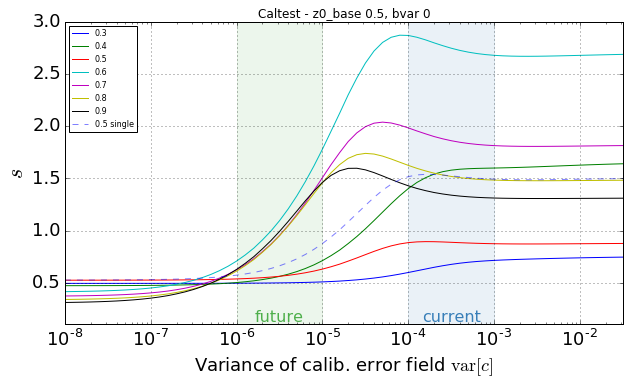

In [18]:
# rhoexplist_indiv_sup = runeuc.caltest_get_rhoexp(z0=z0_sup,varlist=varlist,lmax=lmaxcal,lmin=lmincal,shape=shape,width=width,
#                                                  overwrite=False,doplot=False,saverho=False,varname=varname,reclmin=reclmin)
# rhoexplist_indiv_base = runeuc.caltest_get_rhoexp(z0=z0_base,varlist=varlist,lmax=lmaxcal,lmin=lmincal,shape=shape,width=width,
#                                                   overwrite=False, doplot=False,saverho=False,varname=varname,reclmin=reclmin)
#rhoexplist_indiv_sup = m_caltest_get_rhoexp(z0_base=False, z0_sup=z0_sup, basevar=False,varlist=varlist,lmax=lmaxcal,lmin=lmincal,
#                                 shape=shape,width=width,overwrite=True,doplot=False,saverho=False,varname='rho',
#                                 reclmin=reclmin,outtag=outtag)
# sexplist_indiv_sup = m_caltest_get_rhoexp(z0_base=False, z0_sup=z0_sup, basevar=False,varlist=varlist,lmax=lmaxcal,lmin=lmincal,
#                                 shape=shape,width=width,overwrite=True,doplot=False,saverho=False,varname='s',
#                                 reclmin=reclmin,outtag=outtag)
#----SINGLE, vary z0_base by var[c]
rhoexplist_indiv_base = m_caltest_get_rhoexp(z0_base=False, z0_sup=z0_base, basevar=False,varlist=varlist,lmax=lmaxcal,lmin=lmincal,
                                shape=shape,width=width,overwrite=True,doplot=False,saverho=False,varname=varname,
                                reclmin=reclmin,outtag=outtag)
sexplist_indiv_base = m_caltest_get_rhoexp(z0_base=False, z0_sup=z0_base, basevar=False,varlist=varlist,lmax=lmaxcal,lmin=lmincal,
                                shape=shape,width=width,overwrite=True,doplot=False,saverho=False,varname='s',
                                reclmin=reclmin,outtag=outtag)
#-----

# #two base maps, each with var[c]
# rhoexplist_2base=m_caltest_get_rhoexp(z0_base=z0_base, z0_sup=z0_base, basevar=varlist,varlist=varlist,lmax=lmaxcal,lmin=lmincal,
#                                 shape=shape,width=width,overwrite=True,doplot=False,saverho=False,varname=varname,
#                                 reclmin=reclmin,outtag=outtag)
# #two sup maps, each with var[c]
rhoexplist_2sup=m_caltest_get_rhoexp(z0_base=z0_sup, z0_sup=z0_sup, basevar=varlist,varlist=varlist,lmax=lmaxcal,lmin=lmincal,
                                shape=shape,width=width,overwrite=True,doplot=False,saverho=False,varname=varname,
                                reclmin=reclmin,outtag=outtag)
# #add varying supmap to base map with constant basevar
# rhoexplist=m_caltest_get_rhoexp(z0_base=z0_base,z0_sup=z0_sup,basevar=basevar,varlist=varlist,lmax=lmaxcal,lmin=lmincal,
#                                 shape=shape,width=width,overwrite=True,doplot=False,saverho=False,varname=varname,
#                                 reclmin=reclmin,outtag=outtag)

# #set basevar = var[c] as well, so both maps same variance
# rhoexplist2=m_caltest_get_rhoexp(z0_base=z0_base,z0_sup=z0_sup,basevar=varlist,varlist=varlist,lmax=lmaxcal,lmin=lmincal,
#                                 shape=shape,width=width,overwrite=True,doplot=False,saverho=False,varname=varname,
#                                 reclmin=reclmin,outtag=outtag)
# #----
#get data
##shapestr=r'$C_{{\ell}}^{{\rm cal}}\propto e^{{-(\ell/{0:.0f})^2}}$'.format(width,lmincal,lmaxcal)

#datplot=caltest_getdataplot_forshapecompare(varname,shortvarlist,[shape],[width],[lmincal],[lmaxcal],recminelllist=np.array([reclmin]),colorlist=colorlist,labellist=['Results from sim.'],getunmod=False)
#setting getunmod=false since we don't need cal=0 reference means

#do plotting!
#assuming last entry in varlist, rhoarray is fiducial (var=0)
fig, ax1 = calplotsetup()

#theory line
# ax1.plot(varlist[:-1],rhoexplist[:-1],'--',label='Base+Sup')#linelabel,color=colorlist[1])
# ax1.plot(varlist[:-1],rhoexplist2[:-1],'--',label='Base+Sup, vary Basevar')#linelabel,color=colorlist[1])
# ax1.plot(varlist[:-1],rhoexplist[:-1],'--',label='Base+Sup')#linelabel,color=colorlist[1])
# ax1.plot(varlist[:-1],rhoexplist2[:-1],'--',label='Base+Sup, vary Basevar')#linelabel,color=colorlist[1])

#double z0 vs var[c]
# for z0 in z0list_toplot:
#     rhoexp_temp = m_caltest_get_rhoexp(z0_base=z0_base, z0_sup=z0, basevar=basevar,varlist=varlist,lmax=lmaxcal,lmin=lmincal,
#                                 shape=shape,width=width,overwrite=True,doplot=False,saverho=False,varname=varname,
#                                 reclmin=reclmin,outtag=outtag)
#     ax1.plot(varlist[:-1],rhoexp_temp[:-1],'-',label='{0}'.format(z0))

                 
#single z0 vs var[c]
# for z0 in z0list_toplot:
#     rhoexp_temp = m_caltest_get_rhoexp(z0_base=False, z0_sup=z0, basevar=False,varlist=varlist,lmax=lmaxcal,lmin=lmincal,
#                                 shape=shape,width=width,overwrite=True,doplot=False,saverho=False,varname=varname,
#                                 reclmin=reclmin,outtag=outtag)
        #ax1.plot(varlist[:-1],rhoexp_temp[:-1],'-',label='{0} single'.format(z0))

      
    
# ax1.plot(varlist[:-1],rhoexplist_indiv_sup[:-1],'--',label='{0} single'.format(z0_sup,))#,color=colorlist[0])
# ax1.plot(varlist[:-1],[rhoexplist[-1]]*len(varlist[:-1]),'--',label='Sup_fid',color=colorlist[0])
# ax1.plot(varlist[:-1],rhoexplist_2sup[:-1],'--',label='{0}_dubs'.format(z0_sup,),alpha=.5)#,color=colorlist[0])

ax1.plot(varlist[:-1],rhoexplist_indiv_base[:-1],'--',label='{0} single'.format(z0_base,), alpha=0.5)#,color=colorlist[2])
# ax1.plot(varlist[:-1],[rhoexplist_indiv_base[-1]]*len(varlist[:-1]),'--',label='Base_fid',color=colorlist[2])
# ax1.plot(varlist[:-1],rhoexplist_2base[:-1],'.-',label='base_dubs',color=colorlist[2])

ax1=calplotform(ax1,varname=varname) #format like caltest plot
if basevar==varlist: bvlabel = 'var[c]'
else: bvlabel='{0}'.format(basevar,)
# plt.title('z0base={0}, z0sup={1}, basevar={2}'.format(z0_base,z0_sup,bvlabel))
plt.title('Caltest - z0_base {0:.1f}, bvar {1}'.format(z0_base,bvlabel))
plt.show()

#plot 2 map recons
fig, ax1 = calplotsetup()

#double z0 vs var[c]
for z0 in z0list_toplot:
    rhoexp_temp = m_caltest_get_rhoexp(z0_base=z0_base, z0_sup=z0, basevar=basevar,varlist=varlist,lmax=lmaxcal,lmin=lmincal,
                                shape=shape,width=width,overwrite=True,doplot=False,saverho=False,varname='s',
                                reclmin=reclmin,outtag=outtag)
    ax1.plot(varlist[:-1],rhoexp_temp[:-1],'-',label='{0}'.format(z0))
    
ax1.plot(varlist[:-1],sexplist_indiv_base[:-1],'--',label='{0} single'.format(z0_base,),alpha=.5)#,color=colorlist[0])
ax1=calplotform(ax1,varname='s') #format like caltest plot
plt.title('Caltest - z0_base {0:.1f}, bvar {1}'.format(z0_base,bvlabel))
plt.show()

In [ ]:

for z0 in z0list_toplot:
    rhoexp_temp = m_caltest_get_rhoexp(z0_base=z0_base, z0_sup=z0, basevar=basevar,varlist=varlist,lmax=lmaxcal,lmin=lmincal,
                                shape=shape,width=width,overwrite=True,doplot=False,saverho=False,varname=varname,
                                reclmin=reclmin,outtag=outtag)

In [ ]:
def m_z0toid(multi_list, z0_list):
    """convert a multi_list containing z0 values into one with indices of those values in z0_list, for input into multi_depthtest_get_reclist.
    e.g. m_z0toid([0.5,0.6,(.5,.6)], [0.3,0.4,0.5,0.6]) --> [2, 3, (2,3)]"""
    z0_list=list(z0_list)
    id_mult=[]
    for m in multi_list:
        if type(m)==tuple or type(m)==list:
            rtup=[]
            for z in m:
                rtup.append(z0_list.index(z))
            id_mult.append(tuple(rtup))
        else: id_mult.append(z0_list.index(m))
    return id_mult
            
depthtestz0=np.array([.3,.5,.6,.7,.8,.9])
nbar = 'default'
outtag='mCal02'
#rho_AB/(rho_a*rho_b) vs. r_AB
cldat=multi_get_Cl(justread=True,z0vals=depthtestz0, nbar=nbar, outtag=outtag)
#doMulti = getCombos(range(len(depthtestz0))) #list of z0val map indices to combine for reconstruction.
multi_z = [.3,.6,.7,.8,.9,(.6,.7),(.6,.8),(.6,.9),(.7,.7),(.7,.8),(.7,.9),(.8,.8),(.8,.9),(.9,.9)] #getCombos(range(len(depthtestz0))) #list of z0val map indices to combine for reconstruction.
reclist = multi_depthtest_get_reclist(depthtestz0, multi=m_z0toid(multi_z,depthtestz0), nbar=nbar)
mrs = [MRecStats(cldat, rec, use_nbar_in_r=True) for rec in reclist]

plot_mrslist(mrs, vartypes=['raw'],title=False, fitdeg=0, labplot=True)

print "\nNmaps:",[recdat.Nmap for recdat in reclist]
print "\nMaps to include:\n",[recdat.includeglm for recdat in reclist]
# rhopred = multi_depthtest_get_expected_rho(cldat=cldat,reclist=reclist,varname='rho')
print cldat.bintaglist

In [46]:
print(rpred)
N = len(rpred)
ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, rpred, width, color='r')
# add some text for labels, title and axes ticks
ax.set_ylabel('rpred')
#ax.set_title('Scores by group and gender')
ax.set_xticks(ind + width)
ax.set_xticklabels(('G1', 'G2', 'G3', 'G4', 'G5'))
plt.show()

NameError: name 'rpred' is not defined

In [16]:
if 1: #generate MULTI depthhtest maps (don't want togr)
    Nreal=100
    simmaps=True #do you want to simulate maps, or just do reconstructions (on maps that already exist?
    z0vals=depthtestz0

    doMulti = range(len(depthtestz0)) + [(0,1),(0,2),(2,3),(0,1,2),(0,1,2,3)] #list of z0val maps to combine for reconstruction.

    #z0vals=np.array([0.7])
    if simmaps: #generate maps and do reconstructions
        multi_depthtest_get_glm_and_rec(Nreal=Nreal,z0vals=z0vals,justgetrho=False,minreal=0,dorho=1,dos=True,dochisq=False,dorell=0,dochisqell=False, multi=doMulti, outtag=outtag)
    else: #do recs based on existing galaxy maps
        runeuc.depthtest_iswrec(Nreal,z0vals=z0vals,minreal=0,dorho=1,dos=1,domaps=True, multi=doMulti, outtag=outtag)
        #note, if you just want t compute rho but don't want to redo isw recs
        # change domaps to False

if 0: #plot info about depthtest maps, assumes you've already done isw recs
    for r in xrange(10,20):
         #depthtest_TTscatter(r,depthtestz0,savepngmaps=False)
         pass
    for N in 1000*np.arange(1,10): #how much do results change with Nreal
        #depthtest_plot_rhohist(depthtestz0,varname='rho',firstNreal=1000,startrealat=N)
        pass
    depthtest_plot_rhohist(depthtestz0,varname='rho')
    depthtest_plot_rhohist(depthtestz0,varname='s')
    depthtest_TTscatter(13,depthtestz0,savepngmaps=True)

Initializing Kdata:
kmin=1.000e-05, kmax=1.000e+01, kperlog=300, krcut(add,mult)=(50,20);
 Initializing instance of Cosmology
  Importing cosm params from: testparam.cosm
in getCL, DoNotOverwrite= True
Getting C_l for auto-corr and requested pairs: ['all']
Reading C_l file: output/depthtest_multi_same_nonoise/Cl_output/Cl_depthtest.dat
    Using previously computed auto-corr.
  Checking for previously computed C_l values.
    No new values needed.
isw_bin0
eucz07_bin0
eucz07_v2_bin0
eucz11_bin0
eucz11_v2_bin0
((0,), ['eucz07_bin0'], 'eucz07')
((1,), ['eucz07_v2_bin0'], 'eucz07_v2')
((2,), ['eucz11_bin0'], 'eucz11')
((3,), ['eucz11_v2_bin0'], 'eucz11_v2')
((0, 1), ['eucz07_bin0', 'eucz07_v2_bin0'], '+eucz07+eucz07_v2')
((0, 2), ['eucz07_bin0', 'eucz11_bin0'], '+eucz07+eucz11')
((2, 3), ['eucz11_bin0', 'eucz11_v2_bin0'], '+eucz11+eucz11_v2')
((0, 1, 2), ['eucz07_bin0', 'eucz07_v2_bin0', 'eucz11_bin0'], '+eucz07+eucz07_v2+eucz11')
((0, 1, 2, 3), ['eucz07_bin0', 'eucz07_v2_bin0', 'eucz11_b

        Use :meth:`BinTableHDU.from_columns` for new BINARY tables or :meth:`TableHDU.from_columns` for new ASCII tables instead. [astropy.utils.decorators]


Computing ISW estimator maptag,rectag: iswREC.eucz07_v2 fid
Scaling by best-fit constant bias. Looping through realizations...
    creating dir output/depthtest_multi_same_nonoise/map_output/iswREC.eucz07_v2.fid.fullsky-lmin02.depthtest/
combining along map axis
Computing ISW estimator maptag,rectag: iswREC.eucz11 fid
Scaling by best-fit constant bias. Looping through realizations...
combining along map axis
Computing ISW estimator maptag,rectag: iswREC.eucz11_v2 fid
Scaling by best-fit constant bias. Looping through realizations...
    creating dir output/depthtest_multi_same_nonoise/map_output/iswREC.eucz11_v2.fid.fullsky-lmin02.depthtest/
combining along map axis
Computing ISW estimator maptag,rectag: iswREC.+eucz07+eucz07_v2 fid
Scaling by best-fit constant bias. Looping through realizations...
    creating dir output/depthtest_multi_same_nonoise/map_output/iswREC.+eucz07+eucz07_v2.fid.fullsky-lmin02.depthtest/
combining along map axis
Computing ISW estimator maptag,rectag: iswREC.

SyntaxError: invalid syntax (<ipython-input-13-84f8c1e5469c>, line 2)

()
(1,)
(2,)
(3,)
(1, 2)
(1, 3)
(2, 3)
(1, 2, 3)
